# Локальные дескрипторы

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.ndimage import gaussian_filter
import cv2

## Детектор углов Харриса

### Самописный

In [3]:
def compute_harris(img, sigma=3):
    '''вычисление функции отклика детектора углов Харриса для пикселей полутонового изображения'''

    # Вычисляем производные
    imx = np.zeros(img.shape)
    gaussian_filter(img, (sigma, sigma), (0, 1), imx)
    imy = np.zeros(img.shape)
    gaussian_filter(img, (sigma, sigma), (1, 0), imy)

    # Вычисляем элементы матрицы Харриса
    Wxx = gaussian_filter(imx*imx, sigma)
    Wxy = gaussian_filter(imx* imy, sigma)
    Wyy = gaussian_filter(imy*imy, sigma)

    # определитель и след матрицы
    Wdet = Wxx * Wyy - Wxy**2
    Wtr = Wxx + Wyy

    return Wdet / Wtr

In [4]:
def get_harris_points(harrisim, min_dist=10, threshold=0.1):
    '''возвращает углы на изображении, построенном по функции отклика Харриса,
    min_dist - минимальное число пикселей между углами и границей изображения'''

    # найти отчки-кандидаты, для которых функция отклика больше порога
    corner_threshold = harrisim.max() * threshold
    harrissim_t = (harrisim > corner_threshold) * 1

    # получить координаты кандидатов
    coords = np.array(harrissim_t.nonzero()).T

    # и их значения
    candidate_values = [harrissim_t[c[0], c[1]] for c in coords]

    # сортировка кандидатов
    index = np.argsort(candidate_values)

    # сохранить данные о точках-кандидатах в массиве
    allowed_locations = np.zeros(harrisim.shape)
    allowed_locations[min_dist: -min_dist, min_dist: -min_dist] = 1

    # выбор наилучших точек с учетом min_dist
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i, 0], coords[i, 1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i, 0]-min_dist):(coords[i, 0]+min_dist), (coords[i, 1]-min_dist):(coords[i, 1]+min_dist)]
    return filtered_coords

In [5]:
def plot_harris_points(img, filtered_coords):
    '''нанести на график углы'''
    plt.figure()
    plt.gray()
    plt.imshow(img)
    plt.plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], '*')
    plt.axis('off')
    plt.show()

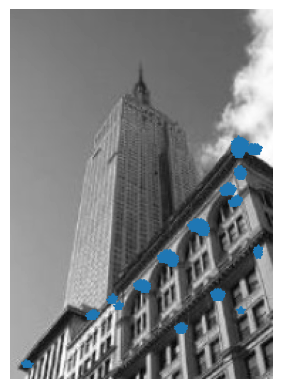

In [6]:
img = np.array(Image.open('pic.jpg').convert('L'))
harissim = compute_harris(img)
filtered_coords = get_harris_points(harissim, min_dist=10, threshold=0.5)
plot_harris_points(img, filtered_coords)

### Через openCV

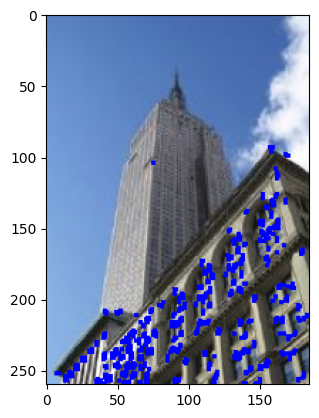

In [8]:
img = cv2.imread('pic.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# изменить тип данных
# установка 32-битной плавающей запятой
operatedImage = np.float32(gray_img)

# применить метод cv2.cornerHarris
# для определения углов с соответствующими
# значения в качестве входных параметров
dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07)

# Результаты отмечены через расширенные углы
dest = cv2.dilate(dest, None)

# Возвращаясь к исходному изображению,
# с оптимальным пороговым значением
img[dest > 0.01 * dest.max()] = [0, 0, 255]
plt.imshow(img)

## Нахождение соответственных точек на изображениях

In [21]:
def get_descriptors(img, filtered_coords, width=5):
    '''для каждой точки вернуть значение пикселей в окрестности шириной 2*width+1'''

    desc = []
    for coords in filtered_coords:
        patch = img[coords[0] - width: coords[0] + width +1,
                    coords[1] - width: coords[1] + width +1].flatten()
        desc.append(patch)
    return desc

In [22]:
def match(desc1, desc2, threshold=0.5):
    '''для каждого дескриптора угловой точки в первом изображении
    найти соответсвующую ему точку во втором изображении,
    применяя нормированную взаимную корреляцию'''

    n = len(desc1)

    # попарные расстояния
    d = -np.ones((len(desc1),len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - np.mean(desc1[i])) / np.std(desc1[i])
            d2 = (desc2[j] - np.mean(desc2[j])) / np.std(desc2[j])
            ncc_value = sum(d1 * d2) / (n-1) 
            if ncc_value > threshold:
                d[i,j] = ncc_value
            
    ndx = np.argsort(-d)
    matchscores = ndx[:,0]
    
    return matchscores

In [23]:
def match_twosided(desc1,desc2,threshold=0.5):
    """ Two-sided symmetric version of match(). """
    
    matches_12 = match(desc1,desc2,threshold)
    matches_21 = match(desc2,desc1,threshold)
    
    ndx_12 = np.where(matches_12 >= 0)[0]
    
    # удалить несимметричные
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    
    return matches_12

In [24]:
def appendimages(im1,im2):
    """ Return a new image that appends the two images side-by-side. """
    
    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]    
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = np.concatenate((im1, np.zeros((rows2-rows1,im1.shape[1]))),axis=0)
    elif rows1 > rows2:
        im2 = np.concatenate((im2, np.zeros((rows1-rows2,im2.shape[1]))),axis=0)
    # if none of these cases they are equal, no filling needed.
    
    return np.concatenate((im1,im2), axis=1)
    
    
def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ Show a figure with lines joining the accepted matches 
        input: im1,im2 (images as arrays), locs1,locs2 (feature locations), 
        matchscores (as output from 'match()'), 
        show_below (if images should be shown below matches). """
    
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = np.vstack((im3,im3))
    
    plt.imshow(im3)
    
    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plt.plot([locs1[i][1],locs2[m][1]+cols1],[locs1[i][0],locs2[m][0]],'c')
    plt.axis('off')

In [ ]:
width = 5
harissim = compute_harris(im1, 5)
filtered_coords1 = get_harris_points(harissim, min_dist=10, threshold=0.5)
d1 = get_descriptors(im1, filtered_coords1, width)

harissim = compute_harris(im2, 5)
filtered_coords2 = get_harris_points(harissim, min_dist=10, threshold=0.5)
d2 = get_descriptors(im2, filtered_coords2, width)

matches = match_twosided(d1, d2)
plt.figure()
plt.gray()
plt.plot_matches(im1, im2, filtered_coords1, filtered_coords2, matches)
plt.show()

## SIFT

Особые точки находятся с помощью гауссианов
$$
D(x, \sigma) = [G_{k\sigma} - G_\sigma]*I = I_{k\sigma - I\sigma},
$$
где $G_\sigma$ - двумерное гауссово ядро, $I_\sigma$ - результат размытия $G_\sigma$-полутонового изображения, $k$ - константа, определяющая разделение при масштабировании.

Особые точки ищутся в виде максимумов и минимумов функции $D(x, \sigma)$. Изнайденных точек исключаются неустойчивые. Для исключения применяются критерии: низкая контрастность и попадание на границу.

Установка https://www.vlfeat.org/

In [35]:
def process_image(imagename, resultname, params='--edge-thresh 10 --peak-thresh 5'):
    '''обработать изображение и сохранить результаты в файл'''

    if imagename[-3:] != 'pgm':
        # создать pgm=файл
        im = Image.open(imagename).convert('L')
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'

    cmmd = str("sift "+imagename+" --output="+resultname+
                " "+params)
    os.system(cmmd)
    print('processed', imagename, 'to', resultname)

In [36]:
def read_features_from_file(filename):
    '''прочитать признаки и вернуть их в виде матрицы'''

    f = np.loadtxt(filename)
    return f[:,:4], f[:, 4:]

In [37]:
def write_features_to_file(filename, locs, desc):
    '''сохранить положения и дескрипторы в файле'''
    
    np.savetxt(filename, np.hstack((locs, desc)))

In [38]:
def plot_features(im,locs,circle=False):
    """ показать изображение с признаками. Вход: изображение в виде массива, 
    locs (строка, столбецб ориентация для каждого признака) """

    def draw_circle(c,r):
        t = np.arange(0,1.01,.01)*2*np.pi
        x = r*np.cos(t) + c[0]
        y = r*np.sin(t) + c[1]
        plt.plot(x,y,'b',linewidth=2)

    plt.imshow(im)
    if circle:
        for p in locs:
            draw_circle(p[:2],p[2]) 
    else:
        plt.plot(locs[:,0],locs[:,1],'ob')
    plt.axis('off')

In [39]:
imname = 'pic.jpg'
im1 = np.array(Image.open(imname).convert('L'))
process_image(imname, 'pic.sift')
'''
l1, d1 = read_features_from_file('tmp.pgm')

plt.figure()
plt.gray()
plot_features(im1, l1, circle=True)
plt.show()
'''

processed tmp.pgm to pic.sift


"\nl1, d1 = read_features_from_file('tmp.pgm')\n\nplt.figure()\nplt.gray()\nplot_features(im1, l1, circle=True)\nplt.show()\n"

### Сопоставление дескрипторов

In [45]:
def match(desc1,desc2):
    """ For each descriptor in the first image, 
        select its match in the second image.
        input: desc1 (descriptors for the first image), 
        desc2 (same for second image). """
    
    desc1 = np.array([d/np.linalg.norm(d) for d in desc1])
    desc2 = np.array([d/np.linalg.norm(d) for d in desc2])
    
    dist_ratio = 0.6
    desc1_size = desc1.shape
    
    matchscores = np.zeros((desc1_size[0]),'int')
    desc2t = desc2.T # precompute matrix transpose
    for i in range(desc1_size[0]):
        dotprods = np.dot(desc1[i,:],desc2t) # vector of dot products
        dotprods = 0.9999*dotprods
        # inverse cosine and sort, return index for features in second image
        indx = np.argsort(np.arccos(dotprods))
        
        # check if nearest neighbor has angle less than dist_ratio times 2nd
        if np.arccos(dotprods)[indx[0]] < dist_ratio * np.arccos(dotprods)[indx[1]]:
            matchscores[i] = int(indx[0])
    
    return matchscores


def appendimages(im1,im2):
    """ Return a new image that appends the two images side-by-side. """
    
    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]    
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = np.concatenate((im1,np.zeros((rows2-rows1,im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = np.concatenate((im2,np.zeros((rows1-rows2,im2.shape[1]))), axis=0)
    # if none of these cases they are equal, no filling needed.
    
    return np.concatenate((im1,im2), axis=1)


def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ Show a figure with lines joining the accepted matches
        input: im1,im2 (images as arrays), locs1,locs2 (location of features), 
        matchscores (as output from 'match'), show_below (if images should be shown below). """
    
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = np.vstack((im3,im3))
    
    # show image
    plt.imshow(im3)
    
    # draw lines for matches
    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plt.plot([locs1[i][0],locs2[m][0]+cols1],[locs1[i][1],locs2[m][1]],'c')
    plt.axis('off')


def match_twosided(desc1,desc2):
    """ Two-sided symmetric version of match(). """
    
    matches_12 = match(desc1,desc2)
    matches_21 = match(desc2,desc1)
    
    ndx_12 = matches_12.nonzero()[0]
    
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[int(matches_12[n])] != n:
            matches_12[n] = 0
    
    return matches_12

## SIFT openCV

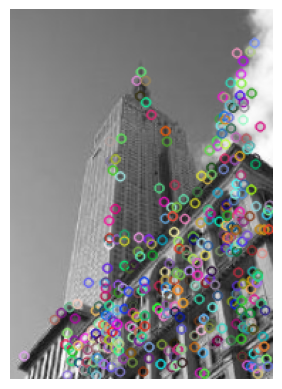

In [9]:
img = cv2.imread('pic.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
 
img=cv2.drawKeypoints(gray,kp,img)
plt.figure()
plt.gray()
plt.axis('off')
plt.imshow(img) 

### Совпадение дескрипторов
https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

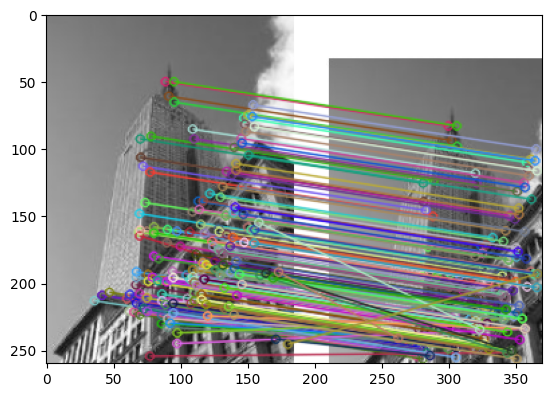

(<matplotlib.image.AxesImage at 0x1b144d37890>, None)

In [46]:
img1 = cv2.imread('pic.jpg',cv2.IMREAD_GRAYSCALE)          # queryImage
img2 = cv2.imread('pic2.jpg',cv2.IMREAD_GRAYSCALE) # trainImage
 
# Initiate SIFT detector
sift = cv2.SIFT_create()
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
 
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
 
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
 
plt.imshow(img3),plt.show()